In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium

## Dataset Preparation - Merging the Bicycle Counter and Bicycle Counts Datasets

In [2]:
# Let's first load the data from the files
file1_path = 'raw_data/Bicycle_Counters_20250122.csv'
file2_path = 'raw_data/Bicycle_Counts_20250122.csv'

# Now, let's read the Excel files into DataFrames
bicycle_counters = pd.read_csv(file1_path)
bicycle_counts = pd.read_csv(file2_path)

In [3]:
# Now, let's merge the datasets on the 'id' column
merged_data = pd.merge(
    bicycle_counters[['id', 'name', 'latitude', 'longitude', 'interval']], 
    bicycle_counts[['id', 'date', 'counts', 'status']], 
    on='id', 
    how='inner'
)

In [4]:
# And save the merged dataset to a new Excel file
output_file_path = 'Merged_Bicycle_Data_20250122.csv'
merged_data.to_csv(output_file_path, index=False)

print(f'Merged file saved as {output_file_path}')

Merged file saved as Merged_Bicycle_Data_20250122.csv


## Data Cleaning on the Merged Dataset

### Some basic checks before moving to the Data Cleaning

In [2]:
# Let's load the merged dataset first
file_path = 'Merged_Bicycle_Data_20250122.csv'
merged_data = pd.read_csv(file_path)

In [3]:
# Let' check the variables in the dataset
merged_data.info()

merged_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6281361 entries, 0 to 6281360
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   name       object 
 2   latitude   float64
 3   longitude  float64
 4   interval   int64  
 5   date       object 
 6   counts     int64  
 7   status     int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 383.4+ MB


,id,name,latitude,longitude,interval,date,counts,status
0,100010017,Staten Island Ferry,40.643387,-74.072075,15,06/03/2023 12:00:00 AM,0,0
1,100010017,Staten Island Ferry,40.643387,-74.072075,15,06/03/2023 12:15:00 AM,0,0
2,100010017,Staten Island Ferry,40.643387,-74.072075,15,06/03/2023 12:30:00 AM,0,0
3,100010017,Staten Island Ferry,40.643387,-74.072075,15,06/03/2023 12:45:00 AM,8,0
4,100010017,Staten Island Ferry,40.643387,-74.072075,15,06/03/2023 01:00:00 AM,0,0


In [4]:
# Now, let's check the missing values
print(merged_data.isnull().sum())

id           0
name         0
latitude     0
longitude    0
interval     0
date         0
counts       0
status       0
dtype: int64


In [ ]:
# Let's first convert 'date' column to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'], format='%m/%d/%Y %I:%M:%S %p')

# And, group by station name and find first and last count dates
station_time_stats = merged_data.groupby(['id', 'name']).agg(
    first_count=('date', 'min'),  # Earliest count recorded
    last_count=('date', 'max')   # Latest count recorded
).reset_index()

# And, check the result
print(station_time_stats)

C:\Users\adity\AppData\Local\Temp\ipykernel_16488\1139587894.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['date'] = pd.to_datetime(merged_data['date'])


In [ ]:
# Let's check the number of day for which the data is available counters-wise
# First let's create a temporary column with only the date (not affecting original data)
merged_data['date_only'] = pd.to_datetime(merged_data['date']).dt.date  

# And, count the number of unique days per counter
station_day_counts = merged_data.groupby(['id', 'name'])['date_only'].nunique().reset_index()

# And, also, rename the column for clarity
station_day_counts.rename(columns={'date_only': 'days_with_data'}, inplace=True)

# Drop the temporary column to avoid affecting future analysis
merged_data.drop(columns=['date_only'], inplace=True)

# And, check the result
print(station_day_counts)

C:\Users\adity\AppData\Local\Temp\ipykernel_10012\1970043176.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['date_only'] = pd.to_datetime(merged_data['date']).dt.date


In [8]:
# Now, let's check the counters with their latitude and longitude and find the counters with same lat and lon
merged_data[['id', 'name', 'latitude', 'longitude']].drop_duplicates()

,id,name,latitude,longitude
0,100010017,Staten Island Ferry,40.643387,-74.072075
308313,300027723,Fountain Ave,40.655606,-73.862951
392568,100057318,Broadway at 50th St,40.761380,-73.984080
413112,100010018,Pulaski Bridge,40.742563,-73.951492
678090,100009426,Manhattan Bridge Ped Path,40.714573,-73.994950
1067970,100010019,Kent Ave btw North 8th St and North 9th St,40.720959,-73.960930
1353601,100010022,Brooklyn Bridge Bike Path,40.709274,-74.000990
1740928,300020241,Brooklyn Bridge Bicycle Path (Roadway),40.712656,-74.004464
1858099,100058279,Kent Ave btw South 6th St. and Broadway,40.711282,-73.968386
1936577,300042336,Pelham Pkwy,40.857669,-73.856154


In [10]:
# Now, let's check sompe specific counters which seems to be duplicated
# Concrete Plant Park
concrete_park_data = [300043073, 300043074, 300040736]
concrete_park_data = merged_data[merged_data['id'].isin(concrete_park_data)][['name', 'date', 'counts']]

print(concrete_park_data.groupby('name')['counts'].agg(
    ['sum', 'min', 'max']
))

# High Bridge
high_bridge_data = [300038506, 300043077, 300043078]
high_bridge_data = merged_data[merged_data['id'].isin(high_bridge_data)][['name', 'date', 'counts']]

print(high_bridge_data.groupby('name')['counts'].agg(
    ['sum', 'min', 'max']
))

# Emmons Ave
emmons_ave_data =[300038509, 300043075, 300043076]
emmons_ave_data = merged_data[merged_data['id'].isin(emmons_ave_data)][['name', 'date', 'counts']]

print(emmons_ave_data.groupby('name')['counts'].agg(
    ['sum', 'min', 'max']
))

# Willis Ave
willis_ave_data = [300028963, 300029647, 300029648]
willis_ave_data = merged_data[merged_data['id'].isin(willis_ave_data)][['name', 'date', 'counts']]

print(emmons_ave_data.groupby('name')['counts'].agg(
    ['sum', 'min', 'max']
))

# Manhattan Bridge
manhattan_bridge_data = [100009426, 100009429, 100005020, 100051865, 100048744, 100047029, 100062893]
manhattan_bridge_data = merged_data[merged_data['id'].isin(manhattan_bridge_data)][['name', 'date', 'counts']]

print(manhattan_bridge_data.groupby('name')['counts'].agg(
    ['sum', 'min', 'max']
))

# Brooklyn Bridge
brooklyn_bridge_data = [100010022, 300020241, 300020904]
brooklyn_bridge_data = merged_data[merged_data['id'].isin(brooklyn_bridge_data)][['name', 'date', 'counts']]

print(brooklyn_bridge_data.groupby('name')['counts'].agg(
    ['sum', 'min', 'max']
))

                              sum  min  max
name                                       
Concrete Plant Park        195627    0  506
Concrete Plant Park Bikes   60083    0   53
Concrete Plant Park Peds   135544    0  505
                      sum  min  max
name                               
High Bridge        377783    0  149
High Bridge Bikes   89561    0  117
High Bridge Peds   288222    0  149
                     sum  min  max
name                              
Emmons Ave        310931    0  495
Emmons Ave Bikes  179019    0   90
Emmons Ave Peds   131912    0  482
                     sum  min  max
name                              
Emmons Ave        310931    0  495
Emmons Ave Bikes  179019    0   90
Emmons Ave Peds   131912    0  482
                                                 sum  min  max
name                                                          
Manhattan Bridge 2012 Test Bike Counter       416543    0  424
Manhattan Bridge 2012 to 2019 Bike Counter   7645129    0  42

In [21]:
# Based on the observations and the information about the counters, let's drop the irrelevant stations
# List of stations to drop
stations_to_drop = [
    "Manhattan Bridge 2012 Test Bike Counter",
    "Forsyth Plaza",
    "Broadway at 50th St",
    "Concrete Plant Park",
    "Concrete Plant Park Peds",
    "High Bridge",
    "High Bridge Peds",
    "Emmons Ave",
    "Emmons Ave Peds",
    "Willis Ave",
    "Willis Ave Peds",
    "2nd Avenue - 26th St S",
    "Manhattan Bridge 2013 to 2018 Bike Counter",
    "1st Avenue - 26th St N - Interference testing",
    "Manhattan Bridge 2012 to 2019 Bike Counter",
    "Manhattan Bridge Display Bike Counter",
    "Comprehensive Brooklyn Bridge Counter",
    "Manhattan Bridge Bike Comprehensive",
    "Kent Ave btw South 6th St. and Broadway"
]

In [22]:
# Let's drop the specified stations from merged_data
filtered_data = merged_data[~merged_data['name'].isin(stations_to_drop)]

# And check the the updated dataset
print(f"Original dataset size: {len(merged_data)}")
print(f"Updated dataset size: {len(filtered_data)}")

Original dataset size: 6281361
Updated dataset size: 3856407


In [23]:
# Now, let's remove observations for counts that has been recorded during an electrical interference
# Let's first define the stations and date ranges to remove
stations_to_filter = {
    "8th Ave at 50th St.": ["2018-06-14", "2019-12-05"],
    "Amsterdam Ave at 86th St.": ["2019-10-24", "2019-12-05"],
    "Columbus Ave at 86th St.": ["2019-10-24", "2019-12-05"],
    "Willis Ave Bikes": ["2022-09-02", "2022-12-01"]
}

In [24]:
# And, apply filtering to remove affected date ranges for each station
for station, date_range in stations_to_filter.items():
    start_date, end_date = date_range
    filtered_data = filtered_data[~((filtered_data['name'] == station) & 
                                    (filtered_data['date'] >= start_date) & 
                                    (filtered_data['date'] <= end_date))]

# And, check the updated dataset size
print(f"Updated dataset size after removing specific date ranges: {len(filtered_data)}")

Updated dataset size after removing specific date ranges: 3788039


In [28]:
# Also, let's save the cleaned dataset
filtered_data.to_csv("cleaned_merged_data.csv", index=False)

## Some Key Observations

I started by merging two datasets: one containing bicycle counts and another with metadata about the bicycle counters, using the common id field. The merged dataset included details like station names, latitude, longitude, timestamp, and recorded bicycle counts. I performed data type conversions, ensuring date was in datetime format and id was numeric. I then examined the dataset for missing values and validated data integrity before proceeding with further analysis.

After merging the data, I conducted an exploratory data analysis to assess data coverage and consistency. I calculated the first and last count timestamps for each station to determine how long each counter had been operational. I also computed the number of unique days for which data was available at each station to assess long-term reliability. As part of this analysis, I identified stations with overlapping latitude and longitude values, indicating possible duplicate counters. Some stations recorded bicycle counts at the same physical location but across different time periods, while others represented aggregated or combined counts. To avoid redundancy, I checked for counters that were installed as temporary test stations, suffered from electrical interference, recorded both pedestrian and bicycle traffic, or had limited periods of data collection.

Based on this assessment, I decided to remove eighteen stations from the dataset. The Manhattan Bridge 2012 Test Bike Counter was dropped as it was only a temporary test counter. Forsyth Plaza and Broadway at 50th St were removed because they contained data for only 2018 and 2019-2020, respectively, making them unsuitable for long-term analysis. Concrete Plant Park, High Bridge, Emmons Ave, and Willis Ave were removed because they represented total counts that included pedestrian traffic, and their corresponding pedestrian-specific counters were also dropped to prevent non-cyclist data from affecting the analysis. Several counters at Manhattan Bridge were removed because they were duplicate counters that had been replaced by newer ones, such as Manhattan Bridge 2013 to 2018 Bike Counter, Manhattan Bridge 2012 to 2019 Bike Counter, and Manhattan Bridge Display Bike Counter. Comprehensive Brooklyn Bridge Counter was also removed because it represented the total of two separate counters, Brooklyn Bridge Bicycle Path (Roadway) and Brooklyn Bridge Bike Path. Additionally, stations like 2nd Avenue - 26th St S and Kent Ave btw North 8th St and North 9th St were removed because they were no longer functional and had data for only a limited number of years. These removals were implemented using .isin() filtering on the name column to exclude the specified counters from the dataset.

In addition to removing entire counters, I also removed specific date ranges from counters that were affected by electrical interference, as these periods contained inaccurate data. For 8th Ave at 50th St., all observations between June 14, 2018, and December 5, 2019 were removed due to documented interference issues. Similarly, for Amsterdam Ave at 86th St. and Columbus Ave at 86th St., we dropped data from October 24, 2019, to December 5, 2019 to eliminate inconsistencies caused by external electrical sources. Lastly, for Willis Ave Bikes, data from September 2, 2022, to December 1, 2022 was removed, as this period was affected by frequent false positives due to interference. These removals were implemented using conditional filtering, ensuring that only the affected observations were excluded while preserving valid data outside these periods.

### Minutes to Hours

To standardize the dataset to an hourly format, we first identified stations with 15-minute intervals and 60-minute intervals using the interval column. Since 60-minute interval data was already recorded on an hourly basis, we retained it as-is. However, for 15-minute interval data, we aggregated the counts by summing up values for every four consecutive 15-minute records to obtain total bicycle counts per hour. To achieve this, we rounded down timestamps to the start of the hour using .dt.floor('H'), ensuring uniformity in time representation. After aggregation, we merged the hourly-adjusted 15-minute data with the original 60-minute data, creating a single dataset where all observations were now at an hourly level. Throughout the process, we maintained the column name date, as it still contained full date and time information, even though it was now at an hourly granularity.

In [32]:
# Let's first load the cleaned merged dataset
file_path = 'cleaned_merged_data.csv'
data = pd.read_csv(file_path)

In [35]:
# And check the variables in the dataset
data.info()

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3788039 entries, 0 to 3788038
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   name       object 
 2   latitude   float64
 3   longitude  float64
 4   interval   int64  
 5   date       object 
 6   counts     int64  
 7   status     int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 231.2+ MB


,id,name,latitude,longitude,interval,date,counts,status
0,100010017,Staten Island Ferry,40.643387,-74.072075,15,2023-06-03 00:00:00,0,0
1,100010017,Staten Island Ferry,40.643387,-74.072075,15,2023-06-03 00:15:00,0,0
2,100010017,Staten Island Ferry,40.643387,-74.072075,15,2023-06-03 00:30:00,0,0
3,100010017,Staten Island Ferry,40.643387,-74.072075,15,2023-06-03 00:45:00,8,0
4,100010017,Staten Island Ferry,40.643387,-74.072075,15,2023-06-03 01:00:00,0,0


In [34]:
# here we are interested in the interval column
# let's check the count for interval column
data['interval'].value_counts().reset_index()

,interval,count
0,15,3501030
1,60,287009


In [36]:
# Let's first convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'])

# Now, let's create an hourly timestamp by rounding down to the start of the hour
data['date'] = data['date'].dt.floor('H')  # Keeps only the hour-level timestamp

# And, separate 15-minute and 60-minute interval data
data_15min = data[data['interval'] == 15]
data_60min = data[data['interval'] == 60]

# And, aggregate 15-minute interval data to hourly by summing up counts
data_15min_hourly = data_15min.groupby(['name', 'latitude', 'longitude', 'date'])['counts'].sum().reset_index()

# And, let's keep 60-minute interval data as is
data_60min = data_60min[['name', 'latitude', 'longitude', 'date', 'counts']]  # Select necessary columns

# Now, let's merge both datasets (hourly aggregated 15-min data + original 60-min data)
hourly_data = pd.concat([data_15min_hourly, data_60min], ignore_index=True)

C:\Users\adity\AppData\Local\Temp\ipykernel_11428\2070215341.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['date'] = data['date'].dt.floor('H')  # Keeps only the hour-level timestamp


In [37]:
# And, check the updated dataset size
print(f"Original dataset size: {len(data)}")
print(f"New dataset size after hourly conversion: {len(hourly_data)}")

Original dataset size: 3788039
New dataset size after hourly conversion: 1162299


In [38]:
# Let's also save the cleaned hourly dataset
hourly_data.to_csv("final_bicycle_counts_NY.csv", index=False)

## Exploratory Data Analysis

In [2]:
# Let's load the final dataset
file_path = 'final_bicycle_counts_NY.csv'
data = pd.read_csv(file_path)

In [3]:
# Let's check the variables in the dataset
data.info()

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162299 entries, 0 to 1162298
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   name       1162299 non-null  object 
 1   latitude   1162299 non-null  float64
 2   longitude  1162299 non-null  float64
 3   date       1162299 non-null  object 
 4   counts     1162299 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 44.3+ MB


,name,latitude,longitude,date,counts
0,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 15:00:00,18
1,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 16:00:00,15
2,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 17:00:00,16
3,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 18:00:00,21
4,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 19:00:00,31


In [43]:
data.tail()

,name,latitude,longitude,date,counts
1162294,Prospect Park West,40.671288,-73.971382,2025-01-20 22:00:00,11
1162295,Prospect Park West,40.671288,-73.971382,2025-01-20 23:00:00,18
1162296,Prospect Park West,40.671288,-73.971382,2025-01-20 23:00:00,6
1162297,Prospect Park West,40.671288,-73.971382,2025-01-20 23:00:00,6
1162298,Prospect Park West,40.671288,-73.971382,2025-01-20 23:00:00,6


In [44]:
# Let's generate the summary statistics for the numerical variables
summary_stats = data.describe()

# And, check the summary stats
print(summary_stats)

           latitude     longitude        counts
count  1.162299e+06  1.162299e+06  1.162299e+06
mean   4.071285e+01 -7.397162e+01  7.173468e+01
std    4.777209e-02  4.087971e-02  1.089482e+02
min    4.058410e+01 -7.407207e+01  0.000000e+00
25%    4.067129e+01 -7.399495e+01  6.000000e+00
50%    4.071053e+01 -7.397138e+01  2.600000e+01
75%    4.074563e+01 -7.396093e+01  9.100000e+01
max    4.085767e+01 -7.385250e+01  1.974000e+03


In [45]:
# Now, let's check the first and last count for each counting station
# Let's first convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'])

# Now, let's get the first and last count per station
first_last_counts = data.groupby('name').agg(
    first_count=('date', 'min'),
    last_count=('date', 'max')
).reset_index()

# Let's check the results now
print(first_last_counts)

                                          name         first_count  \
0                         111th St at 50th Ave 2022-05-09 15:00:00   
1                          8th Ave at 50th St. 2019-12-05 00:00:00   
2                    Amsterdam Ave at 86th St. 2019-12-05 00:00:00   
3       Brooklyn Bridge Bicycle Path (Roadway) 2021-09-14 14:00:00   
4                    Brooklyn Bridge Bike Path 2013-12-19 10:00:00   
5                     Columbus Ave at 86th St. 2019-12-05 00:00:00   
6                    Concrete Plant Park Bikes 2024-04-04 13:00:00   
7        Ed Koch Queensboro Bridge Shared Path 2013-12-05 11:00:00   
8                             Emmons Ave Bikes 2023-12-27 12:00:00   
9                                 Fountain Ave 2022-08-23 10:00:00   
10                           High Bridge Bikes 2023-12-27 10:00:00   
11  Kent Ave btw North 8th St and North 9th St 2016-11-22 17:00:00   
12                   Manhattan Bridge Ped Path 2013-12-04 11:00:00   
13                  

In [46]:
# Now, let's check the number of unique days with data per station
# Let's first create a temporary column with only the date (without time)
data['date_only'] = data['date'].dt.date  

# And, count the number of unique days per station
days_with_data = data.groupby('name')['date_only'].nunique().reset_index()

# Now, let's rename column for clarity
days_with_data.rename(columns={'date_only': 'days_with_data'}, inplace=True)

# Also, let's drop temporary column
data.drop(columns=['date_only'], inplace=True)

# And check the results
print(days_with_data)

                                          name  days_with_data
0                         111th St at 50th Ave             979
1                          8th Ave at 50th St.            1724
2                    Amsterdam Ave at 86th St.            1870
3       Brooklyn Bridge Bicycle Path (Roadway)            1222
4                    Brooklyn Bridge Bike Path            4036
5                     Columbus Ave at 86th St.            1871
6                    Concrete Plant Park Bikes             292
7        Ed Koch Queensboro Bridge Shared Path            4054
8                             Emmons Ave Bikes             369
9                                 Fountain Ave             879
10                           High Bridge Bikes             391
11  Kent Ave btw North 8th St and North 9th St            2978
12                   Manhattan Bridge Ped Path            4063
13                      Ocean Pkwy at Avenue J             505
14                                 Pelham Pkwy         

In [6]:
# Ensure 'date' is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Create a new column with just the date (ignoring time)
data['date_only'] = pd.to_datetime(data['date'].dt.date)

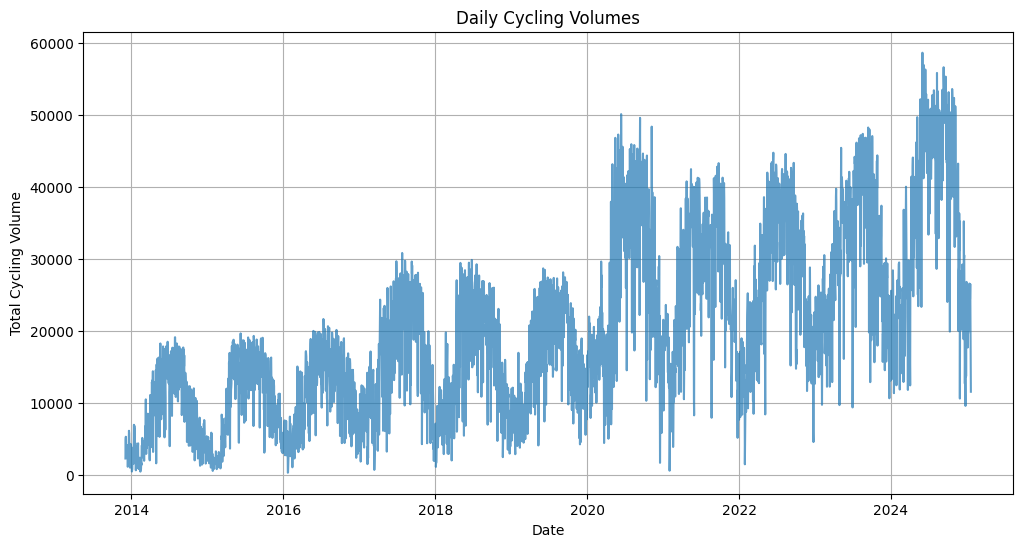

In [7]:
# Set the new 'date_only' column as the index
data.set_index('date_only', inplace=True)

# Resample to daily cycling volumes (sum of counts per day)
daily_data = data['counts'].resample('D').sum()

# Now, let's plot and check the daily trends
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data, alpha=0.7)
plt.title("Daily Cycling Volumes")
plt.xlabel("Date")
plt.ylabel("Total Cycling Volume")
plt.grid(True)
plt.show()

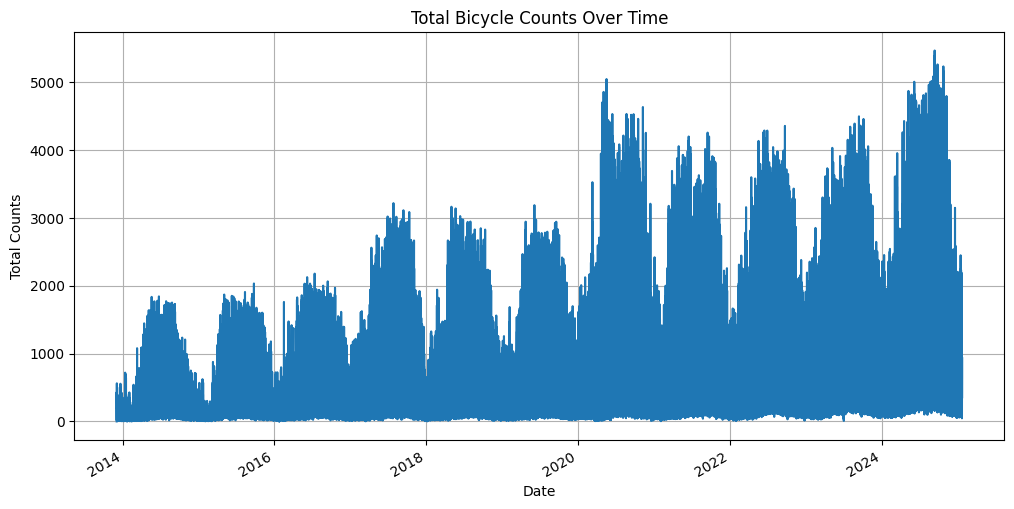

In [48]:
# Now, let's check the trends in bicycle counts over time
# Let's plot total bicycle counts over time
plt.figure(figsize=(12, 6))
data.groupby('date')['counts'].sum().plot()
plt.title('Total Bicycle Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Total Counts')
plt.grid()
plt.show()

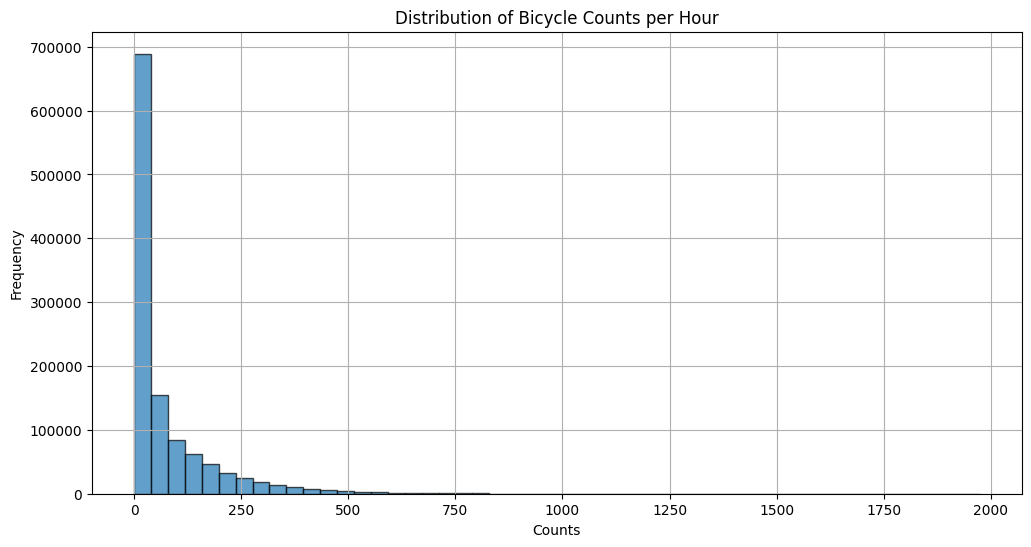

In [67]:
# Now, let's check the distribution of the bicycle counts
# Plot histogram of bicycle counts per hour
plt.figure(figsize=(12, 6))
plt.hist(data['counts'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Bicycle Counts per Hour')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [52]:
print(data.shape)  # This should return (rows, columns)
print(data.head()) # This will show the first few rows

(1162299, 5)
                   name  latitude  longitude                date  counts
0  111th St at 50th Ave  40.74563   -73.8525 2022-05-09 15:00:00      18
1  111th St at 50th Ave  40.74563   -73.8525 2022-05-09 16:00:00      15
2  111th St at 50th Ave  40.74563   -73.8525 2022-05-09 17:00:00      16
3  111th St at 50th Ave  40.74563   -73.8525 2022-05-09 18:00:00      21
4  111th St at 50th Ave  40.74563   -73.8525 2022-05-09 19:00:00      31


In [54]:
# Now, let's check where the counting stations are located
# Let's create a map centered around the average latitude and longitude
bike_map = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=12)

# And, add markers for each unique station
grouped_data = data.groupby('name').first().reset_index()

for _, row in grouped_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='blue', icon='bicycle', prefix='fa')
    ).add_to(bike_map)

# And, check the map
bike_map

In [55]:
# Now, let' check the top 10 stations with highest total bicycle counts
top_stations = data.groupby('name')['counts'].sum().sort_values(ascending=False).head(10)

# Display results
print(top_stations)

name
Williamsburg Bridge Bike Path                 20734675
Ed Koch Queensboro Bridge Shared Path         16729506
Kent Ave btw North 8th St and North 9th St     8338100
Prospect Park West                             6658574
Pulaski Bridge                                 5752534
Brooklyn Bridge Bike Path                      5148772
8th Ave at 50th St.                            4632348
Brooklyn Bridge Bicycle Path (Roadway)         3940028
Amsterdam Ave at 86th St.                      3779757
Columbus Ave at 86th St.                       2871977
Name: counts, dtype: int64


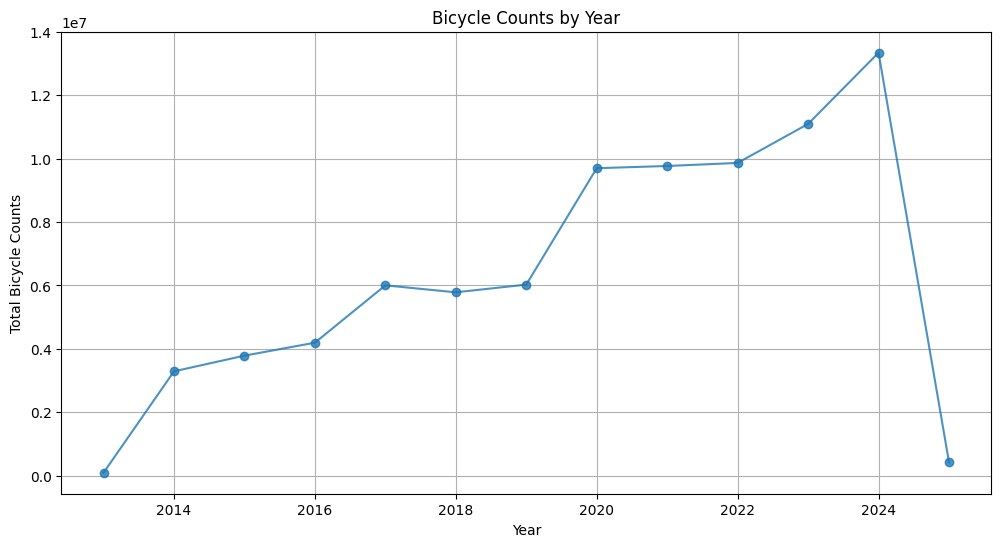

In [63]:
# Now let's check seasonality and yealry trends
# Extract year from the date column
data["year"] = data['date'].dt.year

# Group by year to calculate yearly totals
yearly_data = data.groupby("year")["counts"].sum()

plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index, yearly_data, marker="o", alpha=0.8)
plt.title("Bicycle Counts by Year")
plt.xlabel("Year")
plt.ylabel("Total Bicycle Counts")
plt.grid(True)
plt.show()

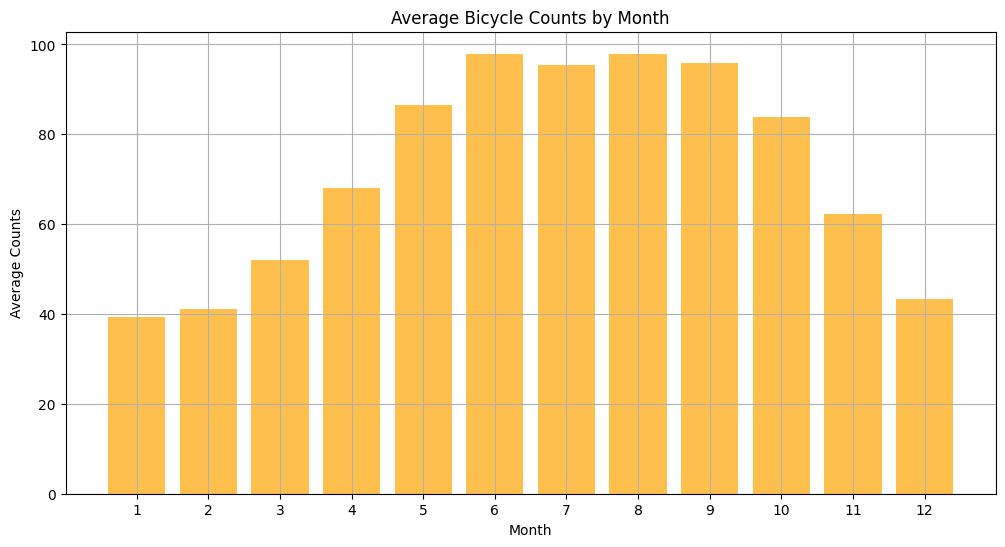

In [64]:
# Now let's analyse monthly patterns to identify the seasonality in cycling volumes
# Extract month from the date column
data["month"] = data['date'].dt.month

# Group by month to calculate average monthly totals
monthly_data = data.groupby("month")["counts"].mean()

# Plot monthly trends
plt.figure(figsize=(12, 6))
plt.bar(monthly_data.index, monthly_data, alpha=0.7, color="orange")
plt.title("Average Bicycle Counts by Month")
plt.xlabel("Month")
plt.ylabel("Average Counts")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

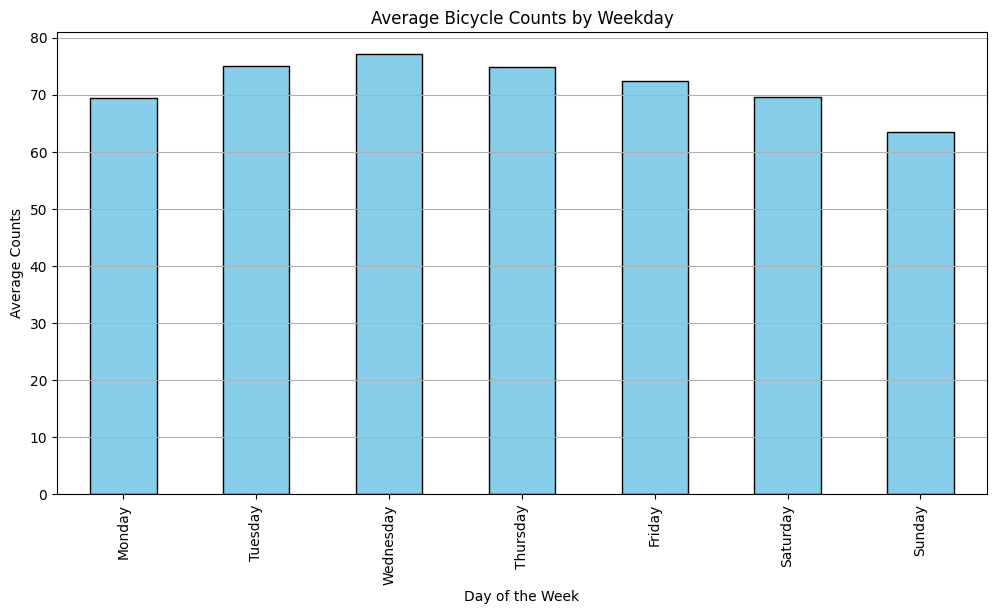

In [65]:
# Now, let's check the weekly trends in bicycle counts
# Let's first extract day of the week
data['weekday'] = data['date'].dt.day_name()

# And, aggregate average counts per weekday
weekday_counts = data.groupby('weekday')['counts'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# And, plot the weekly trends
plt.figure(figsize=(12, 6))
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Bicycle Counts by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Average Counts')
plt.grid(axis='y')
plt.show()

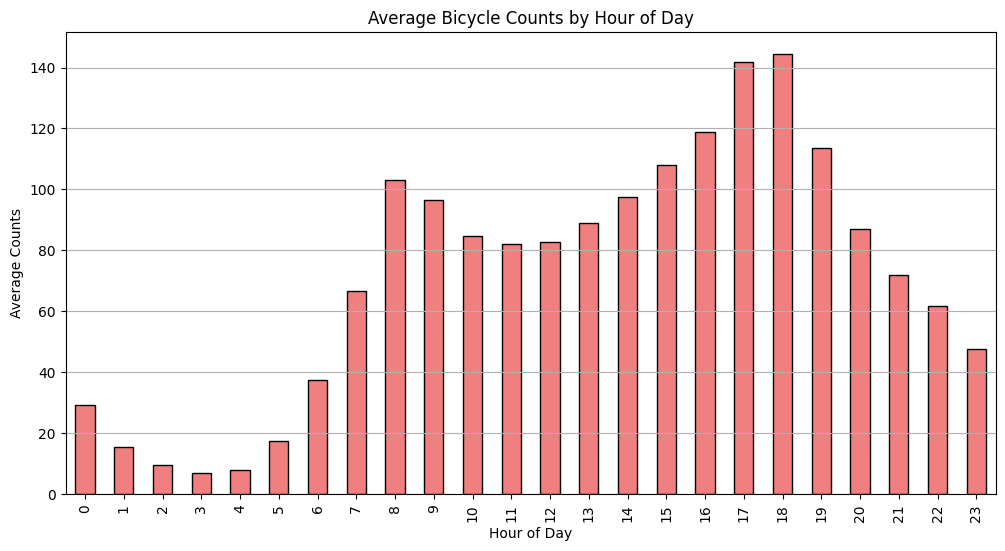

In [66]:
# Now, let's check the hourly trends
# Let's first extract hour of the day
data['hour_of_day'] = data['date'].dt.hour

# And,aggregate average counts per hour
hourly_counts = data.groupby('hour_of_day')['counts'].mean()

# And, plot the hourly trends
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Average Bicycle Counts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Counts')
plt.grid(axis='y')
plt.show()

In [68]:
# Now, let's identify the date range for which the weather data should be downloaded
# Get the date range of the dataset
first_date = data['date'].min()
last_date = data['date'].max()

print(f"Date range of the dataset: {first_date} to {last_date}")

Date range of the dataset: 2013-12-03 14:00:00 to 2025-01-20 23:00:00


## Final Data Cleaning based on the EDA Observations

In [2]:
# Let's load the dataset
data = pd.read_csv("final_bicycle_counts_NY.csv")

In [3]:
# SOme initial checks on the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162299 entries, 0 to 1162298
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   name       1162299 non-null  object 
 1   latitude   1162299 non-null  float64
 2   longitude  1162299 non-null  float64
 3   date       1162299 non-null  object 
 4   counts     1162299 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 44.3+ MB


In [4]:
data.head()

,name,latitude,longitude,date,counts
0,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 15:00:00,18
1,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 16:00:00,15
2,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 17:00:00,16
3,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 18:00:00,21
4,111th St at 50th Ave,40.74563,-73.8525,2022-05-09 19:00:00,31


In [5]:
# Now, let's convert 'timestamp' column to datetime format
data["date"] = pd.to_datetime(data["date"])

# And, filter data from 01/01/2015 onwards
data = data[data["date"] >= "2015-01-01"]

In [7]:
# Now, let's drop data related to the specific station - Concrete Plant Park Bikes
station_to_remove = ["Concrete Plant Park Bikes"]
data = data[~data["name"].isin(station_to_remove)]

In [8]:
# And, save the cleaned dataset to a new CSV file
data.to_csv("cycling_data_newyork_28032025.csv", index=False)

print("Cleaned dataset saved as 'cycling_data_newyork_28032025.csv'.")

Cleaned dataset saved as 'cycling_data_newyork_28032025.csv'.


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1118308 entries, 0 to 1162298
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   name       1118308 non-null  object        
 1   latitude   1118308 non-null  float64       
 2   longitude  1118308 non-null  float64       
 3   date       1118308 non-null  datetime64[ns]
 4   counts     1118308 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 51.2+ MB


In [10]:
# Let's create a date variable from the date columns
data['date'] = data['date'].dt.date

# Now, let's aggregate daily cycling volume per station
data = data.groupby(['name', 'date', 'latitude', 'longitude'])['counts'].sum().reset_index()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37646 entries, 0 to 37645
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       37646 non-null  object 
 1   date       37646 non-null  object 
 2   latitude   37646 non-null  float64
 3   longitude  37646 non-null  float64
 4   counts     37646 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.4+ MB


In [12]:
data.head()

,name,date,latitude,longitude,counts
0,111th St at 50th Ave,2022-05-09,40.74563,-73.8525,120
1,111th St at 50th Ave,2022-05-10,40.74563,-73.8525,165
2,111th St at 50th Ave,2022-05-11,40.74563,-73.8525,197
3,111th St at 50th Ave,2022-05-12,40.74563,-73.8525,206
4,111th St at 50th Ave,2022-05-13,40.74563,-73.8525,178


In [13]:
# And, save the cleaned daily dataset to a new CSV file
data.to_csv("daily_cycling_data_newyork_28032025.csv", index=False)

print("Daily aggregated dataset saved as 'daily_cycling_data_newyork_28032025.csv'.")

Daily aggregated dataset saved as 'daily_cycling_data_newyork_28032025.csv'.


## Daily Data - Cleaning

In [2]:
# Let's load the daily cycle data
df = pd.read_csv('daily_cycling_data_newyork_28032025.csv')

# Let's quickly check the info about the dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37646 entries, 0 to 37645
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       37646 non-null  object 
 1   date       37646 non-null  object 
 2   latitude   37646 non-null  float64
 3   longitude  37646 non-null  float64
 4   counts     37646 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.4+ MB


,name,date,latitude,longitude,counts
0,111th St at 50th Ave,2022-05-09,40.74563,-73.8525,120
1,111th St at 50th Ave,2022-05-10,40.74563,-73.8525,165
2,111th St at 50th Ave,2022-05-11,40.74563,-73.8525,197
3,111th St at 50th Ave,2022-05-12,40.74563,-73.8525,206
4,111th St at 50th Ave,2022-05-13,40.74563,-73.8525,178


In [3]:
# Filter the data between 2015-01-01 and 2024-12-31
start_date = '2015-01-01'
end_date = '2024-12-31'

df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [4]:
# Let's convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# And, extract year from the date
df['year'] = df['date'].dt.year

# And, group by station and year, and count unique dates
bike_counts = df.groupby(['name', 'year'])['date'].nunique().reset_index()

# Filter for years with 365 or more unique dates
valid_years = bike_counts[bike_counts['date'] >= 365]

# Display the valid years for each station
print("Stations with 365 or more days per year:")
print(valid_years)

Stations with 365 or more days per year:
                                       name  year  date
4                       8th Ave at 50th St.  2020   366
10                Amsterdam Ave at 86th St.  2020   366
11                Amsterdam Ave at 86th St.  2021   365
12                Amsterdam Ave at 86th St.  2022   365
16   Brooklyn Bridge Bicycle Path (Roadway)  2022   365
..                                      ...   ...   ...
105           Williamsburg Bridge Bike Path  2019   365
106           Williamsburg Bridge Bike Path  2020   366
107           Williamsburg Bridge Bike Path  2021   365
108           Williamsburg Bridge Bike Path  2022   365
113                        Willis Ave Bikes  2024   366

[73 rows x 3 columns]


In [6]:
# Merge with the original bicycle data to keep only valid years
valid_bike_stations = valid_years[['name', 'year']]
df = pd.merge(df, valid_bike_stations, on=['name', 'year'], how='inner')

# Check the filtered data
print("\nFiltered Bicycle Data (only years with ≥ 365 unique dates):")
print(df['year'].value_counts())
print(df.head())


Filtered Bicycle Data (only years with ≥ 365 unique dates):
year
2024    4385
2020    4026
2022    4015
2021    3650
2017    2555
2018    2555
2019    2555
2016    1464
2015    1460
Name: count, dtype: int64
                  name       date   latitude  longitude  counts  year
0  8th Ave at 50th St. 2020-01-01  40.762348  -73.98612    1696  2020
1  8th Ave at 50th St. 2020-01-02  40.762348  -73.98612    2790  2020
2  8th Ave at 50th St. 2020-01-03  40.762348  -73.98612    2456  2020
3  8th Ave at 50th St. 2020-01-04  40.762348  -73.98612    2387  2020
4  8th Ave at 50th St. 2020-01-05  40.762348  -73.98612    2261  2020


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26665 entries, 0 to 26664
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       26665 non-null  object        
 1   date       26665 non-null  datetime64[ns]
 2   latitude   26665 non-null  float64       
 3   longitude  26665 non-null  float64       
 4   counts     26665 non-null  int64         
 5   year       26665 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
# Calculate the first and last count timestamps for each location
location_time_stats = df.groupby(['name']).agg(
    first_count=('date', 'min'),  # Earliest count
    last_count=('date', 'max')   # Latest count
).reset_index()

# Display the result directly
print(location_time_stats)

                                          name first_count last_count
0                          8th Ave at 50th St.  2020-01-01 2020-12-31
1                    Amsterdam Ave at 86th St.  2020-01-01 2022-12-31
2       Brooklyn Bridge Bicycle Path (Roadway)  2022-01-01 2024-12-31
3                    Brooklyn Bridge Bike Path  2015-01-01 2024-12-31
4                     Columbus Ave at 86th St.  2020-01-01 2024-12-31
5        Ed Koch Queensboro Bridge Shared Path  2015-01-01 2022-12-31
6                                 Fountain Ave  2024-01-01 2024-12-31
7                            High Bridge Bikes  2024-01-01 2024-12-31
8   Kent Ave btw North 8th St and North 9th St  2017-01-01 2024-12-31
9                    Manhattan Bridge Ped Path  2015-01-01 2024-12-31
10                      Ocean Pkwy at Avenue J  2024-01-01 2024-12-31
11                                 Pelham Pkwy  2024-01-01 2024-12-31
12                          Prospect Park West  2017-01-01 2022-12-31
13                  

In [9]:
# Now, let's check the number of unique days with data per station
days_with_data = df.groupby('name')['date'].nunique().reset_index()

# Now, let's rename column for clarity
days_with_data.rename(columns={'date': 'days_with_data'}, inplace=True)

# And check the results
print(days_with_data)

                                          name  days_with_data
0                          8th Ave at 50th St.             366
1                    Amsterdam Ave at 86th St.            1096
2       Brooklyn Bridge Bicycle Path (Roadway)             731
3                    Brooklyn Bridge Bike Path            3287
4                     Columbus Ave at 86th St.            1461
5        Ed Koch Queensboro Bridge Shared Path            2557
6                                 Fountain Ave             365
7                            High Bridge Bikes             366
8   Kent Ave btw North 8th St and North 9th St            2556
9                    Manhattan Bridge Ped Path            3288
10                      Ocean Pkwy at Avenue J             366
11                                 Pelham Pkwy             365
12                          Prospect Park West            1826
13                              Pulaski Bridge            2191
14                         Staten Island Ferry         

## EDA on the Daily Data

In [2]:
# Let's load the daily data
daily_data = pd.read_csv("daily_cycling_data_newyork_28032025.csv")

In [3]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37646 entries, 0 to 37645
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       37646 non-null  object 
 1   date       37646 non-null  object 
 2   latitude   37646 non-null  float64
 3   longitude  37646 non-null  float64
 4   counts     37646 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.4+ MB


In [4]:
# Now, let's convert 'timestamp' column to datetime format
daily_data["date"] = pd.to_datetime(daily_data["date"])

In [5]:
# Calculate the first and last count timestamps for each location
location_time_stats = daily_data.groupby(['name']).agg(
    first_count=('date', 'min'),  # Earliest count
    last_count=('date', 'max')   # Latest count
).reset_index()

# Display the result directly
print(location_time_stats)

                                          name first_count last_count
0                         111th St at 50th Ave  2022-05-09 2025-01-20
1                          8th Ave at 50th St.  2019-12-05 2025-01-20
2                    Amsterdam Ave at 86th St.  2019-12-05 2025-01-20
3       Brooklyn Bridge Bicycle Path (Roadway)  2021-09-14 2025-01-20
4                    Brooklyn Bridge Bike Path  2015-01-01 2025-01-20
5                     Columbus Ave at 86th St.  2019-12-05 2025-01-19
6        Ed Koch Queensboro Bridge Shared Path  2015-01-01 2025-01-20
7                             Emmons Ave Bikes  2023-12-27 2024-12-29
8                                 Fountain Ave  2022-08-23 2025-01-20
9                            High Bridge Bikes  2023-12-27 2025-01-20
10  Kent Ave btw North 8th St and North 9th St  2016-11-22 2025-01-20
11                   Manhattan Bridge Ped Path  2015-01-01 2025-01-20
12                      Ocean Pkwy at Avenue J  2023-09-04 2025-01-20
13                  

In [6]:
# Now, let's check the number of unique days with data per station
days_with_data = daily_data.groupby('name')['date'].nunique().reset_index()

# Now, let's rename column for clarity
days_with_data.rename(columns={'date': 'days_with_data'}, inplace=True)

# And check the results
print(days_with_data)

                                          name  days_with_data
0                         111th St at 50th Ave             979
1                          8th Ave at 50th St.            1724
2                    Amsterdam Ave at 86th St.            1870
3       Brooklyn Bridge Bicycle Path (Roadway)            1222
4                    Brooklyn Bridge Bike Path            3671
5                     Columbus Ave at 86th St.            1871
6        Ed Koch Queensboro Bridge Shared Path            3662
7                             Emmons Ave Bikes             369
8                                 Fountain Ave             879
9                            High Bridge Bikes             391
10  Kent Ave btw North 8th St and North 9th St            2978
11                   Manhattan Bridge Ped Path            3670
12                      Ocean Pkwy at Avenue J             505
13                                 Pelham Pkwy             444
14                          Prospect Park West         

In [7]:
# Now, let' check the top 10 stations with highest total bicycle counts
top_stations = daily_data.groupby('name')['counts'].sum().sort_values(ascending=False).head(10)

# Display results
print(top_stations)

name
Williamsburg Bridge Bike Path                 19077333
Ed Koch Queensboro Bridge Shared Path         15596252
Kent Ave btw North 8th St and North 9th St     8338100
Prospect Park West                             6658574
Pulaski Bridge                                 5752534
8th Ave at 50th St.                            4632348
Brooklyn Bridge Bike Path                      4590740
Brooklyn Bridge Bicycle Path (Roadway)         3940028
Amsterdam Ave at 86th St.                      3779757
Columbus Ave at 86th St.                       2871977
Name: counts, dtype: int64


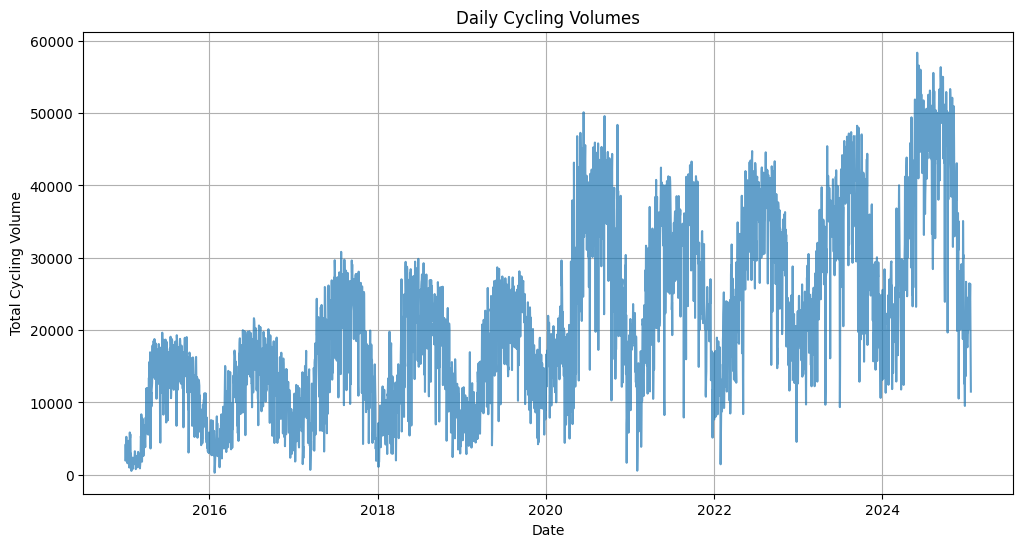

In [8]:
# Let's check the daily trends
daily_data.set_index("date", inplace=True)

# First let's resample to daily cycling volumes
daily_data = daily_data["counts"].resample("D").sum()

# Now, let's plot and check the daily trends
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data, alpha=0.7)
plt.title("Daily Cycling Volumes")
plt.xlabel("Date")
plt.ylabel("Total Cycling Volume")
plt.grid(True)
plt.show()